<!--NOTEBOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="./figures/LogoOpenclassrooms.png">
<font size="4">
    
Cette étude a été réalisée dans le cadre du 6ème projet de ma formation Datascientist dispensée en MOOC par 

<font color='blus'>Openclassrooms / écoles Centrale-Supélec</font>.




<p></p><p></p><p></p>





**Le problème posé :**


*Stack Overflow est un site célèbre de question-réponses liées au développement informatique. Pour poser une question sur ce site, il faut entrer plusieurs tags de manière à retrouver facilement la question par la suite. Pour les utilisateurs expérimentés cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.*

*Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tags pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.*



**Solutions mises en oeuvre**

Les solutions de suggestion de tags présentés ici se basent sur des modèles supervisés de machine learning.

Les modèles mis en oeuvre : 
    * Multinomial Naive Bayes
    * Multinomial Naive Bayes chaîné
    * Regression logistic (GSCV)
    * SGD (GSCV)
    * Multinomial Bernoulli 

Ce notebook utilise les données issues des notebooks : 


**`P6_DadaAnalysis.ipynb`**

**`P6_UnsupervizedMethods.ipynb`**



In [82]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# <font color=blus>4. Supervized methods</font>

## <font color=blus>4.0. Encoding TAGs issued from train and test data-sets</font>

* Multiple TAGs are assigned to a unique POST.

    This lead to deal with a multi-label classification issue.

    All labels (TAGs) are one hot encoded.


* Train and test data-sets do not have same assigned TAGs set.

    This leads to a different number of encoded columns for each data-set.

    For having same number of columns for train and test datasets, encoding process uses the union of train and 
    test assigned TAGs .



In [ ]:
import pandas as pd
file_name="./data/test_StackOverFlow_BodyTitleTags.csv"
ser_sof_tags_test=pd.read_csv(file_name)['Tags']
print(ser_sof_tags_test.shape)

file_name="./data/train_StackOverFlow_BodyTitleTags.csv"
ser_sof_tags_train=pd.read_csv(file_name)['Tags']
print(ser_sof_tags_train.shape)



**<font color='blue'>List of unique TAGs is built</font>**

In [ ]:
import p6_util

# String of TAGs are converted as list of TAGS.
list_list_tags  = ser_sof_tags_train.apply(p6_util.clean_marker_text, leading_marker='<', trailing_marker='>').tolist()
print(len(list_list_tags))
list_list_tags += ser_sof_tags_test.apply(p6_util.clean_marker_text, leading_marker='<', trailing_marker='>').tolist()
print(len(list_list_tags))
#list_ref_tags = list(set(list_ref_tags))
#print(len(list_ref_tags))
list_ref_tags = list()
for list_tags in list_list_tags :
    list_ref_tags += [tag for tag in list_tags]

list_ref_tags = list(set(list_ref_tags))
print(len(list_ref_tags))


**<font color='blue'>TAGs from train and test datasets are encoded and saved into CSR matrix</font>**

In [ ]:
import p5_util
import p6_util

csr_matrix_encoded_train_tags, list_ref_train_tags = p6_util.p6_encode_ser_tag_2_csrmatrix(ser_sof_tags_train, list_ref_tags)
print("csr_matrix_encoded_train_tags : {}".format(csr_matrix_encoded_train_tags.shape))

file_name="./data/csr_matrix_encoded_train_tags.dump"
p5_util.object_dump(csr_matrix_encoded_train_tags,file_name)

In [ ]:
import p5_util
import p6_util

csr_matrix_encoded_test_tags, list_ref_test_tags = p6_util.p6_encode_ser_tag_2_csrmatrix(ser_sof_tags_test, list_ref_tags)
print("csr_matrix_encoded_test_tags : {}".format(csr_matrix_encoded_test_tags.shape))

file_name="./data/csr_matrix_encoded_test_tags.dump"
p5_util.object_dump(csr_matrix_encoded_test_tags,file_name)

## <font color=blus>4.2. Test dataset processing</font>

Processing results in : 
    * POSTs standardization
    * POSTs vectorization (words embedded on dictionary issued from most weighted tokens).
    * TAGs from POSTs are encoded in a one hot way and saved into CSR matrix.

In [ ]:
import pandas as pd
file_name="./data/test_StackOverFlow_BodyTitleTags.csv"
df_sof_test=pd.read_csv(file_name)
print(df_sof_test.shape)

**<font color='blue'>Test dataset standardization</font>**


Process is applied on a POST that is built from merged `Body` and `Title` columns

In [ ]:
df_sof_test['Body']=df_sof_test['Body']+df_sof_test['Title']

In [ ]:
import p6_util
ser_sof_body_test = p6_util.p6_df_standardization(df_sof_test.Body)

**<font color='blue'>Test dataset Vectorization</font>**

* Loading TF-IDF vectorizer; this is same operator used for train data-set vectorization.

In [ ]:
import p5_util
file_name="./data/csr_matrix_tfidf_ngram1_b.dump"
csr_matrix = p5_util.object_load(file_name)
print(csr_matrix.shape)

file_name="./data/vectorizer_tfidf_ngram1_b.dump"
vectorizer = p5_util.object_load(file_name)

In [ ]:
P6/p6_util.pycsr_matrix_tdif_1gram_test = vectorizer.transform(ser_sof_body_test)
csr_matrix_tdif_1gram_test.shape

**<font color='blue'>Save of test CSR matrix issued from test POST vectorization</font>**

In [ ]:
import p5_util
file_name="./data/csr_matrix_tdif_1gram_test.dump"
p5_util.object_dump(csr_matrix_tdif_1gram_test,file_name)
csr_matrix_tdif_1gram_test.shape

## <font color=blus>4.3. Loading SOF TAGs</font>

Those TAGs from SOF database are used as targets for M.L. process.


In [1]:
import pandas as pd
file_name="./data/StackOverFlowTags.csv"
df_sof_tags=pd.read_csv(file_name)
df_sof_tags.shape

(50000, 2)

## <font color=blus>4.4. Loading vectorized train dataset and encoded train target dataset</font>

**Loading TF-IDF data-set containing trained vectorized POSTs**

In [2]:
import p5_util

file_name="./data/csr_matrix_tfidf_1gram.dump"
csr_matrix_tfidf_1gram = p5_util.object_load(file_name)
print(csr_matrix_tfidf_1gram.shape)

p5_util.object_load : fileName= ./data/csr_matrix_tfidf_1gram.dump
(16359, 3641)


**Loading encoded train target data-set**

In [3]:
import p5_util

file_name="./data/csr_matrix_encoded_train_tags.dump"
csr_matrix_encoded_train_tags = p5_util.object_load(file_name)
print(csr_matrix_encoded_train_tags.shape)

p5_util.object_load : fileName= ./data/csr_matrix_encoded_train_tags.dump
(24604, 8385)


## <font color=blus>4.5. Loading vectorized test dataset and encoded test target dataset</font>

**Loading TF-IDF data-set containing test vectorized POSTs**

In [4]:
import p5_util
file_name="./data/csr_matrix_tdif_1gram_test.dump"
csr_matrix_tdif_1gram_test = p5_util.object_load(file_name)
csr_matrix_tdif_1gram_test.shape

p5_util.object_load : fileName= ./data/csr_matrix_tdif_1gram_test.dump


(16359, 6304)

**Loading encoded test target data-set**

In [5]:
import p5_util

file_name="./data/csr_matrix_encoded_test_tags.dump"
csr_matrix_encoded_test_tags = p5_util.object_load(file_name)
print(csr_matrix_encoded_test_tags.shape)

p5_util.object_load : fileName= ./data/csr_matrix_encoded_test_tags.dump
(16359, 8385)


In [6]:
dict_cls_score = dict()

In [7]:
X_train = csr_matrix_tfidf_1gram
y_train = csr_matrix_encoded_train_tags

X_test = csr_matrix_tdif_1gram_test
y_test = csr_matrix_encoded_test_tags

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

col_min = min(y_train.shape[1],  y_test.shape[1] )

print("\nMin col for target : \n"+str(col_min))

if False:
    y_train = y_train[:, :col_min]
    y_test  = y_test[:,:col_min]

    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(16359, 3641) (24604, 8385) (16359, 6304) (16359, 8385)

Min col for target : 
8385


## <font color='blus'>4.6. Evaluation of Multinomial Bernouilli Naive Bayes classifier</font>

**<font color='blue'>Loading SOF TAGs </font>**

In [71]:
import pandas as pd
file_name="./data/StackOverFlowTags.csv"
df_sof_tags=pd.read_csv(file_name)
df_sof_tags.shape

(50000, 2)

**<font color='blue'>Loading encoded test target data-set</font>**

In [72]:
import p5_util

file_name="./data/csr_matrix_encoded_test_tags.dump"
csr_matrix_encoded_test_tags = p5_util.object_load(file_name)
print(csr_matrix_encoded_test_tags.shape)

p5_util.object_load : fileName= ./data/csr_matrix_encoded_test_tags.dump
(16359, 8385)


**<font color='blue'>Loading TF-IDF test data-set containing vectorized POSTs</font>**

In [73]:
import p5_util
file_name="./data/csr_matrix_tdif_1gram_test.dump"
csr_matrix_tdif_1gram_test = p5_util.object_load(file_name)
csr_matrix_tdif_1gram_test.shape

p5_util.object_load : fileName= ./data/csr_matrix_tdif_1gram_test.dump


(16359, 6304)

**<font color='blue'>Loading encoded train target data-set</font>**

In [74]:
import p5_util

file_name="./data/csr_matrix_encoded_train_tags.dump"
csr_matrix_encoded_train_tags = p5_util.object_load(file_name)
print(csr_matrix_encoded_train_tags.shape)

p5_util.object_load : fileName= ./data/csr_matrix_encoded_train_tags.dump
(24604, 8385)


**<font color='blue'>Loading TF-IDF train data-set containing vectorized POSTs</font>**

In [75]:
import p5_util

file_name="./data/csr_matrix_tfidf_ngram1_b.dump"
csr_matrix_tfidf_ngram1_b = p5_util.object_load(file_name)
print(csr_matrix_tfidf_ngram1_b.shape)

p5_util.object_load : fileName= ./data/csr_matrix_tfidf_ngram1_b.dump
(24604, 6304)


In [76]:
X_train = csr_matrix_tfidf_ngram1_b
y_train = csr_matrix_encoded_train_tags

X_test = csr_matrix_tdif_1gram_test
y_test = csr_matrix_encoded_test_tags


col_min = min(y_train.shape[1],  y_test.shape[1] )

print("\nMin col for target : "+str(col_min))

if False:
    y_train = y_train[:, :col_min]
    y_test  = y_test[:,:col_min]

print("\n *** X_train= {} y_train={} X_test={} y_test={}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))



Min col for target : 8385

 *** X_train= (24604, 6304) y_train=(24604, 8385) X_test=(16359, 6304) y_test=(16359, 8385)


In [77]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.multiclass import OneVsRestClassifier
N_JOBS=-1
cls_ber = OneVsRestClassifier(BernoulliNB(), n_jobs=N_JOBS).fit(X_train, y_train)

In [78]:
cls_ber

OneVsRestClassifier(estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True),
          n_jobs=-1)

**Compute accuracy**

In [110]:
y_pred = cls_ber.predict(X_test)

In [111]:
import p6_util
import p5_util
cls_name = 'Bernoulli NB'
cls_score = p6_util.p6_supervized_mean_accuracy_score(csr_matrix_encoded_test_tags, y_pred)
print("Mean accuracy score for "+cls_name+" : {0:1.2F} %".format(cls_score*100))


dict_cls_score[cls_name] = cls_score

file_name='./data/dict_cls_score.dump'
p5_util.object_dump(dict_cls_score, file_name)
dict_cls_score

48055
Mean accuracy score for Bernoulli NB : 19.57 %


{'Multinomial Bernoulli': 0.19567162626157528,
 'Multinomial NB': 0.016897305171158047,
 'Bernoulli NB': 0.19567162626157528}

## <font color=blus>4.7. Applying Naive Bayes classifier</font>

### <font color=blus>4.7.1. Training N.B. classifier</font>

**Training classifier**

one versus Rest leads having one classifier per class.

`OneVsRestClassifier` classifier is used because of multiple classes. 

Then, one classifier per class is fitted.



In [81]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
import numpy as np

cls_mnb = OneVsRestClassifier(MultinomialNB(), n_jobs=-1).fit(X_train, y_train)


In [83]:
cls_mnb

OneVsRestClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
          n_jobs=-1)

### <font color='blus'>4.7.2.Classifier evaluation</font>

**TAGs predictions and probabilities for test dataset**

In [106]:
y_pred = cls_mnb.predict(X_test)

In [107]:
import p6_util
cls_mnb_score = p6_util.p6_supervized_mean_accuracy_score(csr_matrix_encoded_test_tags, y_pred)
print("Accuracy score for Multinomial NB : {0:1.2F} %".format(cls_mnb_score*100))

48055
Accuracy score for Multinomial NB : 1.69 %


In [108]:
cls_mnb_score

0.016897305171158047

In [109]:
import p6_util
import p5_utilAA
cls_name = 'Multinomial NB'
cls_score = p6_util.p6_supervized_mean_accuracy_score(csr_matrix_encoded_test_tags, y_pred)
print("Accuracy score for "+cls_name+" : {0:1.2F} %".format(cls_score*100))


dict_cls_score[cls_name] = cls_score

file_name='./data/dict_cls_score.dump'
p5_util.object_dump(dict_cls_score, file_name)
dict_cls_score

48055
Accuracy score for Multinomial NB : 1.69 %


{'Multinomial Bernoulli': 0.19567162626157528,
 'Multinomial NB': 0.016897305171158047}

**<font color=blue>P({Tag_i}|Post)</font>**

In [ ]:
y_proba = model.predict_proba(X_test)

y_proba.shape

**Compute accuracy**

In [18]:
from sklearn.metrics import accuracy_score
y_pred = cls_mnb.predict(X_test)

cls_mnb_score = accuracy_score(y_test  ,y_pred)

print("Accuracy score for MNB classifier : {0:1.2F} %".format(cls_mnb_score*100))

dict_cls_score['MNB'] = cls_mnb_score

Accuracy score for MNB classifier : 0.34 %


In [19]:
import p5_util

file_name="./data/dict_cls_score.dump"
p5_util.object_dump(dict_cls_score,file_name)


## <font color='blus'>4.8. Chained Multinomial Naive Bayes classifier</font>

In [20]:
import p5_util

file_name="./data/dict_cls_score.dump"
dict_cls_score = p5_util.object_load(file_name)


p5_util.object_load : fileName= ./data/dict_cls_score.dump


In [21]:
from skmultilearn.problem_transform import ClassifierChain

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

chained_classifier_mnb = ClassifierChain(MultinomialNB())

In [22]:
chained_classifier_mnb.fit(X_train , y_train)

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: R

ClassifierChain(classifier=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
        order=None, require_dense=[True, True])

In [113]:
y_pred = chained_classifier_mnb.predict(X_test)

NameError: name 'chained_classifier_mnb' is not defined

In [111]:
import p6_util
import p5_util
cls_name = 'Chained Multinomial NB'
cls_score = p6_util.p6_supervized_mean_accuracy_score(csr_matrix_encoded_test_tags, y_pred)
print("Mean accuracy score for "+cls_name+" : {0:1.2F} %".format(cls_score*100))


dict_cls_score[cls_name] = cls_score

file_name='./data/dict_cls_score.dump'
p5_util.object_dump(dict_cls_score, file_name)
dict_cls_score

48055
Mean accuracy score for Bernoulli NB : 19.57 %


{'Multinomial Bernoulli': 0.19567162626157528,
 'Multinomial NB': 0.016897305171158047,
 'Bernoulli NB': 0.19567162626157528}

## <font color='blus'>4.9. SGD classifier</font>

In [91]:
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier

sgd_classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)).fit(X_train, y_train)

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 12 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 21 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 23 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 25 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 29 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packa

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 213 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 214 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 220 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 222 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 226 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 228 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 448 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 449 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 450 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 453 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 455 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 462 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 622 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 623 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 626 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 629 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 634 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 637 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 867 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 871 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 873 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 879 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 880 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 883 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1103 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1108 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1111 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1112 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1113 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1114 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1359 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1366 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1369 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1374 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1379 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1385 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1563 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1566 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1567 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1571 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1575 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1581 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1745 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1750 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1758 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1761 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1762 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1767 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1988 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1989 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1991 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1998 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2014 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2017 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2239 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2258 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2261 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2263 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2272 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2279 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2496 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2503 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2505 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2508 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2516 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2517 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2717 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2721 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2729 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2731 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2734 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2735 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2969 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2970 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2975 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2981 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2982 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2983 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3209 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3214 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3216 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3221 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3222 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3226 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3442 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3448 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3454 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3461 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3462 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3464 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3696 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3700 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3705 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3712 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3714 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3729 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3925 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3928 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3932 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3937 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3940 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3941 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4166 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4176 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4177 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4178 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4183 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4192 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4388 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4394 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4395 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4400 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4411 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4414 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4704 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4708 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4714 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4718 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4721 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4724 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4958 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4960 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4963 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4969 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4971 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4972 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5193 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5200 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5203 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5207 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5208 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5214 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5448 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5450 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5454 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5457 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5459 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5460 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5648 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5657 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5658 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5667 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5670 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5677 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5893 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5898 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5899 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5902 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5919 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5924 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6148 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6150 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6153 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6154 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6156 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6159 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6343 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6345 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6346 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6351 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6362 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6364 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6567 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6569 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6570 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6572 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6573 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6574 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6771 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6773 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6777 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6779 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6783 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6785 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7023 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7025 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7026 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7028 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7031 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7033 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7244 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7247 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7252 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7259 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7260 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7268 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7453 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7456 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7457 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7465 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7481 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7482 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7659 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7664 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7668 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7674 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7678 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7679 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7860 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7864 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7866 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7867 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7871 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7882 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8063 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8068 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8076 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8077 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8078 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8084 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8276 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8277 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8283 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8284 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8287 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8290 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

In [114]:
y_pred = sgd_classifier.predict(X_test)

In [115]:
import p6_util
import p5_util
cls_name = 'SGD'
cls_score = p6_util.p6_supervized_mean_accuracy_score(csr_matrix_encoded_test_tags, y_pred)
print("Mean accuracy score for "+cls_name+" : {0:1.2F} %".format(cls_score*100))


dict_cls_score[cls_name] = cls_score

file_name='./data/dict_cls_score.dump'
p5_util.object_dump(dict_cls_score, file_name)
dict_cls_score

48055
Mean accuracy score for SGD : 4.01 %


{'Multinomial Bernoulli': 0.19567162626157528,
 'Multinomial NB': 0.016897305171158047,
 'Bernoulli NB': 0.19567162626157528,
 'SGD': 0.04007907605868276}

## <font color='blus'>4.10. Grid Search CV Logistic regression & One vs rest</font>

In [94]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

dict_param_grid = {
    'estimator__C': [ 1e-3, 1e-2, 1e-1, 1e0, 5, 10],
    'estimator__penalty': ['l2'],
    'n_jobs': [-1]
}

estimator = OneVsRestClassifier(LogisticRegression())
gscv_lr_classifier  = GridSearchCV(estimator, dict_param_grid)

gscv_lr_classifier.fit(X_train, y_train)

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 169 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 172 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 173 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 179 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 182 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 184 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 324 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 327 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 330 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 332 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 333 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 337 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 459 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 462 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 463 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 464 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 467 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 469 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 594 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 595 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 596 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 597 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 598 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 599 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 709 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 713 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 716 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 717 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 727 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 728 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 890 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 901 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 904 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 905 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 911 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 912 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1052 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1058 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1059 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1061 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1062 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1063 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1221 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1223 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1226 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1227 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1228 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1229 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1379 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1385 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1387 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1390 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1391 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1392 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1527 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1529 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1531 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1533 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1534 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1535 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1653 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1656 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1657 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1658 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1659 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1664 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1803 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1810 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1822 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1824 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1831 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1834 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1963 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1971 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1973 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1974 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1976 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1979 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2103 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2107 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2115 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2116 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2118 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2119 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2272 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2273 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2278 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2279 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2280 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2286 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2426 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2431 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2432 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2435 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2444 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2446 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2584 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2590 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2592 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2598 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2600 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2601 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2731 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2734 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2735 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2736 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2739 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2740 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2919 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2921 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2925 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2928 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2932 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2935 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3070 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3071 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3073 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3076 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3078 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3081 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3246 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3252 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3253 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3256 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3259 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3263 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3425 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3426 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3429 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3432 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3436 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3437 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3589 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3594 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3595 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3603 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3604 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3608 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3747 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3749 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3750 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3752 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3754 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3755 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3890 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3891 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3895 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3897 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3899 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3900 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4023 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4026 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4030 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4034 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4040 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4041 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4166 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4167 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4170 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4173 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4174 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4176 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4300 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4303 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4305 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4306 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4307 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4313 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4460 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4463 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4464 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4469 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4477 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4478 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4637 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4647 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4652 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4653 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4654 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4655 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4840 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4847 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4848 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4850 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4851 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4853 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4976 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4979 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4983 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4984 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4985 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4987 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5104 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5105 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5106 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5107 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5108 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5113 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5241 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5242 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5244 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5245 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5246 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5247 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5382 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5392 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5393 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5396 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5398 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5401 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5517 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5521 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5522 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5523 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5527 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5530 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5667 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5670 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5672 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5677 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5684 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5685 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5828 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5829 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5830 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5831 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5833 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5835 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5974 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5976 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5978 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5984 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5985 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5986 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6139 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6142 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6143 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6148 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6150 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6153 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6290 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6292 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6295 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6298 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6301 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6307 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6446 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6448 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6449 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6455 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6456 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6457 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6579 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6580 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6584 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6585 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6586 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6587 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6734 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6735 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6736 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6737 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6738 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6743 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6869 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6876 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6881 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6885 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6893 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6895 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7039 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7040 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7042 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7045 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7052 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7054 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7211 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7214 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7215 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7217 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7218 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7220 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7364 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7373 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7381 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7387 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7389 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7392 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7521 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7522 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7526 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7529 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7530 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7531 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7674 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7675 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7678 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7679 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7683 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7684 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7811 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7816 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7817 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7821 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7825 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7826 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7946 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7947 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7949 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7950 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7953 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7957 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8106 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8108 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8109 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8112 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8114 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8115 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8246 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8248 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8250 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8252 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8254 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8259 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8374 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8375 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8378 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8379 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8380 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 277 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 278 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 281 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 295 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 296 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 300 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 690 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 712 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 715 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 725 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 732 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 733 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1041 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1054 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1065 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1066 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1072 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1074 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1417 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1423 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1428 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1433 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1435 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1465 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1786 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1791 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1797 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1800 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1801 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1808 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2082 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2096 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2102 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2108 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2111 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2113 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2427 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2433 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2438 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2456 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2468 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2480 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2825 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2826 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2827 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2829 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2835 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2836 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3162 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3164 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3173 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3174 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3175 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3177 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3502 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3508 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3511 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3512 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3516 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3530 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3790 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3807 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3811 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3813 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3827 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3829 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4182 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4185 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4188 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4189 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4211 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4213 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4609 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4611 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4613 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4614 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4615 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4638 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4967 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4993 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5003 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5005 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5012 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5019 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5353 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5361 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5372 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5373 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5383 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5384 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5691 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5693 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5701 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5702 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5703 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5717 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6005 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6013 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6022 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6027 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6035 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6040 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6314 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6320 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6321 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6322 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6333 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6335 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6692 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6694 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6696 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6704 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6716 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6719 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6955 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6961 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6962 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6965 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6967 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6969 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7288 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7293 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7297 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7306 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7320 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7323 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7610 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7614 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7622 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7628 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7629 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7632 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8012 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8021 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8023 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8034 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8043 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8054 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 14 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 16 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 19 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 24 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 26 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packa

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 339 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 341 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 346 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 357 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 359 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 361 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 694 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 696 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 703 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 704 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 711 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 714 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1013 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1018 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1029 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1032 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1038 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1039 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1261 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1262 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1265 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1269 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1273 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1282 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1585 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1593 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1594 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1602 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1604 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1617 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1876 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1878 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1881 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1890 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1893 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1908 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2235 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2237 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2243 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2252 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2269 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2276 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2649 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2650 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2651 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2657 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2658 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2659 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2945 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2948 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2951 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2952 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2954 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2961 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3261 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3264 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3271 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3277 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3281 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3287 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3632 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3633 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3639 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3640 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3670 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3679 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3992 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4002 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4009 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4017 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4021 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4022 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4348 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4350 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4351 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4353 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4358 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4360 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4635 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4636 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4640 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4642 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4644 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4645 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4940 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4957 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4964 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4965 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4973 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4977 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5343 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5351 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5359 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5364 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5366 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5376 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5676 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5682 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5708 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5713 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5721 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5732 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6012 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6015 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6024 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6028 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6033 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6034 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6367 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6371 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6379 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6381 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6386 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6393 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6745 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6747 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6761 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6780 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6794 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6796 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7111 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7128 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7131 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7137 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7165 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7172 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7604 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7607 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7611 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7618 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7619 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7636 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7906 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7931 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7932 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7934 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7952 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7987 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8288 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8289 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8297 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8298 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8301 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8302 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'estimator__C': [0.001, 0.01, 0.1, 1.0, 5, 10], 'estimator__penalty': ['l2'], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [95]:
print (gscv_lr_classifier.best_score_)
print (gscv_lr_classifier.best_params_)

0.052349211510323526
{'estimator__C': 10, 'estimator__penalty': 'l2', 'n_jobs': -1}


In [96]:
lr_classifier = OneVsRestClassifier(LogisticRegression(penalty='l2', C=10, n_jobs=-1))

In [97]:
lr_classifier.fit(X_train, y_train)

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 12 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 21 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 23 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 25 is present in all training examples.
  str(class

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 207 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 213 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 214 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 220 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 222 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 226 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 436 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 439 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 441 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 442 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 444 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 448 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 604 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 607 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 609 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 611 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 612 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 622 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 814 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 819 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 820 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 834 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 836 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 839 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1058 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1059 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1061 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1062 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1075 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1079 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1286 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1290 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1291 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1293 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1303 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1305 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1527 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1529 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1531 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1533 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1534 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1535 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1679 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1681 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1689 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1697 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1699 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1701 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1919 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1929 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1930 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1932 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1952 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1954 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2182 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2183 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2184 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2185 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2191 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2196 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2401 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2413 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2420 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2421 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2426 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2431 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2652 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2654 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2655 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2656 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2662 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2665 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2868 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2871 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2882 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2883 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2884 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2886 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3092 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3094 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3096 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3100 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3103 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3117 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3368 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3369 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3370 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3375 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3378 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3381 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3528 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3537 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3539 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3541 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3557 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3561 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3800 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3805 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3809 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3810 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3812 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3819 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4013 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4014 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4020 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4026 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4040 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4041 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4255 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4257 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4258 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4262 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4265 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4266 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4500 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4505 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4529 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4538 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4541 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4551 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4807 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4827 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4828 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4832 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4834 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4840 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5011 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5017 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5021 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5022 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5026 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5032 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5235 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5237 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5241 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5244 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5246 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5248 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5469 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5473 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5474 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5479 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5480 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5481 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5677 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5684 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5686 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5687 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5688 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5690 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5902 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5919 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5924 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5926 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5934 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5936 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6139 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6143 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6148 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6150 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6153 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6154 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6343 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6345 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6346 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6351 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6362 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6364 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6563 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6567 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6569 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6570 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6572 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6573 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6758 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6766 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6771 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6773 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6777 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6779 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7016 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7023 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7025 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7026 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7028 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7031 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7231 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7233 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7241 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7244 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7247 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7252 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7434 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7435 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7440 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7442 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7447 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7448 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7637 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7639 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7641 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7644 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7646 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7653 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7829 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7833 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7836 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7838 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7839 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7845 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8004 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8020 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8022 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8026 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8030 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8039 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8236 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8239 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8243 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8246 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8248 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8250 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=None)

In [116]:
y_pred = lr_classifier.predict(X_test)

In [117]:
import p6_util
import p5_util
cls_name = 'Linear Regression'
cls_score = p6_util.p6_supervized_mean_accuracy_score(csr_matrix_encoded_test_tags, y_pred)
print("Mean accuracy score for "+cls_name+" : {0:1.2F} %".format(cls_score*100))


dict_cls_score[cls_name] = cls_score

file_name='./data/dict_cls_score.dump'
p5_util.object_dump(dict_cls_score, file_name)
dict_cls_score

48055
Mean accuracy score for Linear Regression : 24.69 %


{'Multinomial Bernoulli': 0.19567162626157528,
 'Multinomial NB': 0.016897305171158047,
 'Bernoulli NB': 0.19567162626157528,
 'SGD': 0.04007907605868276,
 'Linear Regression': 0.24686296951409842}

## <font color='blus'>4.11. GSCV SGD classifier</font>

In [119]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
dict_param_grid = {
    'estimator__alpha': [1e-3, 5*1e-3, 1e-2],
    'estimator__penalty': ['l2'],
    'n_jobs': [-1]
}

estimator = OneVsRestClassifier(SGDClassifier())
gscv_sgd_cls  = GridSearchCV(estimator, dict_param_grid, cv=5)
gscv_sgd_cls.fit(X_train, y_train)

print (gscv_sgd_cls.best_score_)
print (gscv_sgd_cls.best_params_)

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 12 is present in all training e

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 169 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 172 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 179 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 182 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 184 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 192 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 367 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 372 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 382 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 383 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 384 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 389 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 550 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 555 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 556 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 557 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 559 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 567 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 695 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 697 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 698 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 701 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 702 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 706 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 904 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 905 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 911 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 912 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 917 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 925 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1094 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1097 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1100 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1103 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1108 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1111 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1290 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1291 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1293 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1303 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1305 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1309 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1461 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1463 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1466 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1468 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1473 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1478 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1620 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1623 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1627 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1630 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1631 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1636 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1784 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1785 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1793 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1794 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1803 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1824 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1979 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1980 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1986 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1988 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1989 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1991 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2156 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2157 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2159 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2163 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2165 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2168 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2328 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2329 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2331 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2333 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2334 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2338 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2541 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2542 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2546 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2547 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2548 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2552 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2705 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2706 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2707 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2708 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2711 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2714 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2905 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2909 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2919 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2928 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2935 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2936 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3117 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3118 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3119 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3124 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3125 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3126 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3336 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3356 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3358 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3359 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3361 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3363 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3515 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3518 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3524 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3526 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3527 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3528 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3754 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3759 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3760 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3764 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3767 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3773 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3925 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3926 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3928 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3932 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3937 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3940 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4113 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4115 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4118 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4119 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4122 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4124 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4265 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4266 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4271 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4274 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4280 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4284 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4448 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4449 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4452 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4453 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4457 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4460 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4677 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4686 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4693 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4698 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4700 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4704 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4896 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4897 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4905 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4910 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4915 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4916 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5078 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5079 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5081 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5083 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5086 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5096 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5261 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5266 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5268 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5274 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5276 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5277 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5464 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5466 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5469 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5473 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5474 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5479 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5630 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5632 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5635 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5636 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5640 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5643 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5813 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5816 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5817 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5818 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5819 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5820 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5984 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5985 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5986 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5991 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5992 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5994 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6159 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6163 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6166 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6167 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6172 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6173 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6351 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6357 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6362 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6364 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6365 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6366 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6563 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6567 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6568 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6569 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6570 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6572 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6743 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6744 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6746 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6749 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6754 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6755 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6928 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6929 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6938 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6942 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6946 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6947 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7126 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7129 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7133 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7134 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7136 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7138 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7275 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7276 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7283 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7290 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7291 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7294 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7447 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7448 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7452 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7453 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7456 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7457 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7603 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7606 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7608 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7612 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7616 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7620 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7794 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7795 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7799 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7803 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7804 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7805 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7949 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7950 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7953 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7957 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7958 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7959 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8144 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8145 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8147 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8148 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8149 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8157 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8330 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8332 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8334 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8336 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8338 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8345 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 488 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 499 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 542 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 552 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 553 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 597 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1174 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1178 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1187 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1204 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1227 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1234 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2054 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2071 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2088 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2103 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2120 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2142 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2857 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2875 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2880 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2904 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2906 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2910 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3558 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3563 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3566 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3615 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3630 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3636 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4230 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4241 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4250 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4256 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4294 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4306 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4951 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5006 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5040 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5041 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5058 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5066 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5587 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5603 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5620 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5623 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5651 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5654 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6348 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6356 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6374 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6378 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6383 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6384 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7067 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7077 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7084 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7096 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7154 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7200 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8079 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8086 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8088 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8113 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8135 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8142 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 212 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 240 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 246 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 262 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 277 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 278 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 971 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 982 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 986 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 996 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1015 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1025 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/s

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1670 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1674 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1696 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1700 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1702 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1734 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2108 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2111 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2113 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2114 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2117 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2123 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2756 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2763 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2778 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2786 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2795 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2803 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3321 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3333 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3373 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3374 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3394 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3398 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3868 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3877 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3885 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3896 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3913 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3922 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4466 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4496 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4504 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4520 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4525 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4535 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5167 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5171 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5187 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5202 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5206 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5228 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5786 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5802 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5806 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5814 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5815 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5842 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6370 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6376 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6380 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6395 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6400 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6425 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6845 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6855 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6860 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6874 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6879 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6899 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7473 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7501 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7509 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7524 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7568 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7586 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8191 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8207 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8209 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8221 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8240 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8244 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 515 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 524 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 534 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 565 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 579 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 593 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1191 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1192 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1195 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1207 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1212 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1213 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1722 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1731 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1732 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1736 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1740 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1746 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2227 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2235 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2237 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2247 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2269 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2271 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2790 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2817 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2821 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2823 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2824 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2833 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3390 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3412 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3435 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3449 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3452 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3486 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4028 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4049 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4061 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4078 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4104 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4106 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4745 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4755 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4763 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4768 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4774 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4776 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5359 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5364 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5372 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5378 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5424 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5449 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5960 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6000 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6001 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6013 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6015 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6028 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6482 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6489 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6498 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6518 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6552 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6601 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7155 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7176 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7179 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7182 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7185 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7195 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7740 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7755 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7761 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7776 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7797 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7832 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 14 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 16 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 26 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 34 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 41 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 42 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-pack

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 616 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 638 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 644 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 652 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 655 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 660 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1148 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1149 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1153 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1177 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1181 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1188 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1713 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1717 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1719 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1753 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1759 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1781 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2490 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2507 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2555 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2574 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2581 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2587 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3027 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3048 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3056 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3058 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3061 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3066 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3632 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3633 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3639 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3640 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3670 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3690 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4267 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4279 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4322 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4323 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4329 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4351 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4842 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4871 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4882 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4964 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4977 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4978 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5610 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5628 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5647 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5663 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5665 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5668 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6221 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6246 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6312 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6319 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6328 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6355 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7075 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7101 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7111 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7128 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7131 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7137 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7762 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7789 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7793 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7823 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7828 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7834 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

0.00910421069744757
{'estimator__alpha': 0.001, 'estimator__penalty': 'l2', 'n_jobs': -1}


In [121]:
best_sgd_classifier \
= OneVsRestClassifier(SGDClassifier(alpha=0.001, penalty='l2', n_jobs=-1)).fit(X_train, y_train)

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 12 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 21 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 23 is present in all training

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 207 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 213 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 214 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 220 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 222 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 226 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 448 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 449 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 450 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 453 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 455 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 462 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 622 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 623 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 626 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 629 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 634 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 637 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 867 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 871 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 873 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 879 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 880 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 883 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/sit

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1108 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1111 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1112 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1113 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1114 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1124 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1359 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1366 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1369 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1374 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1379 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1385 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1571 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1575 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1581 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1587 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1590 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1591 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1758 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1761 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1762 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1767 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1768 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1776 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2014 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2017 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2018 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2020 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2024 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2027 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2279 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2280 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2286 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2288 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2289 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2291 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2516 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2517 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2518 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2520 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2527 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2533 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2721 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2729 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2731 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2734 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2735 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2736 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2986 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2988 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2991 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2996 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3007 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3008 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3238 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3241 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3242 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3246 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3252 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3253 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3475 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3478 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3480 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3481 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3491 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3493 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3744 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3747 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3749 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3750 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3754 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3759 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3948 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3953 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3955 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3965 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3972 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3973 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4216 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4220 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4221 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4231 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4235 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4237 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4429 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4449 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4453 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4460 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4464 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4469 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4764 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4772 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4773 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4791 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4796 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4797 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4996 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4997 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5000 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5011 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5017 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5021 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5235 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5237 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5241 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5244 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5246 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5248 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5469 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5473 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5474 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5479 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5480 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5481 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5677 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5684 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5686 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5687 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5688 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5690 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5919 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5924 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5926 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5934 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5936 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5938 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6150 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6153 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6154 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6156 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6159 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6163 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6345 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6346 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6351 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6362 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6364 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6365 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6569 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6570 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6572 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6573 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6574 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6575 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6766 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6771 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6773 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6777 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6779 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6783 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7023 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7025 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7026 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7028 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7031 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7033 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7244 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7247 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7252 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7259 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7260 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7268 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7453 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7456 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7457 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7465 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7481 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7482 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7659 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7664 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7668 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7674 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7678 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7679 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7860 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7864 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7866 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7867 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7871 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7882 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8063 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8068 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8076 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8077 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8078 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8084 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8263 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8265 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8266 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8267 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8268 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8276 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

In [122]:
y_pred = best_sgd_classifier.predict(X_test)

In [123]:
import p6_util
import p5_util
cls_name = 'SGD'
cls_score = p6_util.p6_supervized_mean_accuracy_score(csr_matrix_encoded_test_tags, y_pred)
print("Mean accuracy score for "+cls_name+" : {0:1.2F} %".format(cls_score*100))


dict_cls_score[cls_name] = cls_score

file_name='./data/dict_cls_score.dump'
p5_util.object_dump(dict_cls_score, file_name)
dict_cls_score

48055
Mean accuracy score for SGD : 3.99 %


{'Multinomial Bernoulli': 0.19567162626157528,
 'Multinomial NB': 0.016897305171158047,
 'Bernoulli NB': 0.19567162626157528,
 'SGD': 0.03987098116741234,
 'Linear Regression': 0.24686296951409842}

In [124]:
dict_cls_score

{'Multinomial Bernoulli': 0.19567162626157528,
 'Multinomial NB': 0.016897305171158047,
 'Bernoulli NB': 0.19567162626157528,
 'SGD': 0.03987098116741234,
 'Linear Regression': 0.24686296951409842}

## <font color='blus'>4.12. Powered SGD classifier</font>

In [ ]:
from sklearn.linear_model import SGDClassifier
from skmultilearn.problem_transform import LabelPowerset
power_classifier_sgd = LabelPowerset(SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None))
power_classifier_sgd.fit(X_train, y_train)

y_pred = power_classifier_sgd.predict(X_test)

power_classifier_sgd_score = accuracy_score(y_test[:,:col_min]  ,y_pred[:,:col_min])

print("Accuracy mean score for Powered SGD classifier : {0:1.2F} %".format(power_classifier_sgd_score*100))

dict_cls_score['Powered SGD'] = power_classifier_sgd_score

In [ ]:
import p5_util
file_name='./data/dict_cls_score.dump'
dict_cls_score = p5_util.object_load(file_name)

dict_cls_score['GSCV SGD Regression'] = gscv_sgd_cls.best_score_
p5_util.object_dump(dict_cls_score, file_name)

## <font color='blus'>4.13. Classifiers results</font>

In [ ]:
dict_cls_score

In [125]:
import pandas as pd
df_result = pd.DataFrame.from_dict( dict_cls_score, orient='index')
df_result.reset_index(inplace=True)
df_result.rename(columns={'index':'Classifier',0:'Score'}, inplace=True)
df_result

,Classifier,Score
0,Multinomial Bernoulli,0.195672
1,Multinomial NB,0.016897
2,Bernoulli NB,0.195672
3,SGD,0.039871
4,Linear Regression,0.246863


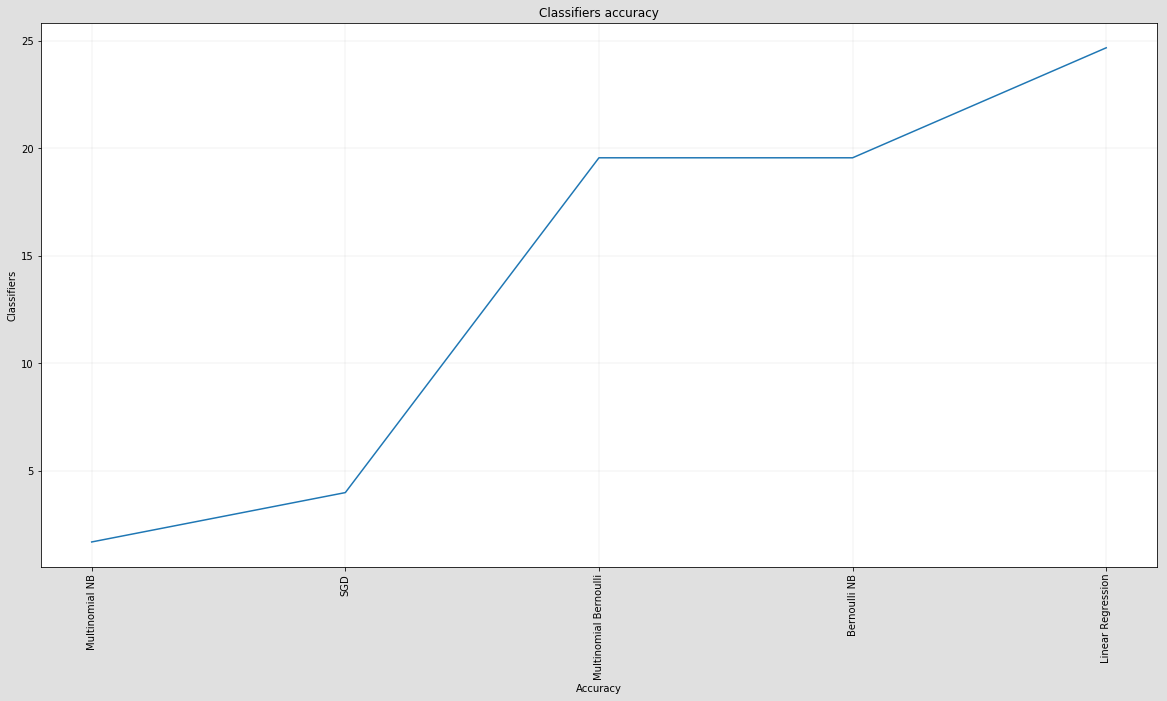

In [128]:
import p6_util_plot
title = "Classifiers accuracy"
p6_util_plot.ser_item_occurency_plot(df_result.Classifier, df_result.Score*100, item_count=None, title=title,\
                                    p_reverse=False)